In [1]:
import os
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from deap import base, creator, tools
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import GridSearchCV
from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score

# Build LSTM model where only lstm_units2 is optimized

In [2]:
def build_lstm_model_ga(lstm_units1, lstm_units2, input_shape, dropout_rate=0.3, learning_rate=0.001, optimizer_type=0):
    model = Sequential()
    
    # First LSTM Layer
    model.add(LSTM(int(lstm_units1), return_sequences=True, input_shape=input_shape))
    # model.add(Dropout(dropout_rate))
    
    # Second LSTM Layer
    model.add(LSTM(int(lstm_units2), return_sequences=True))
    # model.add(Dropout(dropout_rate))

    # ✅ Third LSTM Layer with 16 units
    model.add(LSTM(16, return_sequences=False))
    
    # Output layer
    model.add(Dense(1))

    # Optimizer
    optimizer = Adam(learning_rate=learning_rate) if optimizer_type == 0 else RMSprop(learning_rate=learning_rate)
    model.compile(loss='mse', optimizer=optimizer)
    
    return model


# Fitness function for optimizing lstm_units

In [3]:
def eval_lstm_fitness(individual, X_train, y_train, X_val, y_val, dropout_rate=0.3, learning_rate=0.001, optimizer_type=0):
    lstm_units1 = int(individual[0])
    lstm_units2 = int(individual[1])

    # Clamp to ensure valid range
    lstm_units1 = max(10, min(100, lstm_units1))
    lstm_units2 = max(10, min(100, lstm_units2))

    print(f"\nEvaluating LSTM1 = {lstm_units1}, LSTM2 = {lstm_units2}")

    model = build_lstm_model_ga(
        int(lstm_units2),int(lstm_units1), (X_train.shape[1], X_train.shape[2]), dropout_rate, learning_rate, optimizer_type
    )

    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=0)

    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=32, verbose=1, callbacks=[early_stopping])

    val_loss = np.min(history.history['val_loss'])
    regularization = 0.001 * (lstm_units1 + lstm_units2)
    fitness = 1 / (1 + np.sqrt(val_loss) + regularization)

    print(f"✅ Minimum Validation Loss: {val_loss:.4f}")
    print(f"✅ Fitness: {fitness:.6f} (Reg: {regularization:.4f})")

    return (fitness, val_loss)

# Configure Genetic Algorithm for LSTM optimization

In [4]:
def setup_ga_lstm():
    if not hasattr(creator, "FitnessMin"):
        creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
    if not hasattr(creator, "Individual"):
        creator.create("Individual", list, fitness=creator.FitnessMin)

    toolbox = base.Toolbox()
    toolbox.register("lstm_units1", random.randint, 10, 100)
    toolbox.register("lstm_units2", random.randint, 10, 100)
    
    # Individual will now have 2 genes
    toolbox.register("individual", tools.initCycle, creator.Individual,
                     (toolbox.lstm_units1, toolbox.lstm_units2), n=1)
    
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)
    toolbox.register("mate", tools.cxBlend, alpha=0.5)
    toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=5, indpb=0.5)
    toolbox.register("select", tools.selTournament, tournsize=3)

    return toolbox

In [5]:
def run_ga_lstm(toolbox, X_train, y_train, X_val, y_val, dropout_rate=0.3, learning_rate=0.001, optimizer_type=0, population_size=10, generations=10):

    toolbox.register("evaluate", lambda ind: eval_lstm_fitness(
        ind, X_train, y_train, X_val, y_val,
        dropout_rate, learning_rate, optimizer_type
    ))

    pop = toolbox.population(n=population_size)
    loss_history = []

    global_best = None
    global_best_loss = float('inf')

    for gen in range(generations):
        print(f"\n--- Generation {gen + 1}/{generations} ---")

        offspring = list(map(toolbox.clone, toolbox.select(pop, len(pop))))

        for child1, child2 in zip(offspring[::2], offspring[1::2]):
            if random.random() < 0.5:
                toolbox.mate(child1, child2)
                del child1.fitness.values, child2.fitness.values

        for mutant in offspring:
            if random.random() < 0.2:
                toolbox.mutate(mutant)
                del mutant.fitness.values

        for ind in offspring:
            if not ind.fitness.valid:
                fitness, val_loss = toolbox.evaluate(ind)
                ind.fitness.values = (fitness,)
                ind.val_loss = val_loss

                if val_loss < global_best_loss:
                    global_best = creator.Individual(ind)
                    global_best_loss = val_loss

        pop[:] = offspring

        best_ind = tools.selBest(pop, 1)[0]
        best_loss = getattr(best_ind, 'val_loss', toolbox.evaluate(best_ind)[1])
        loss_history.append(best_loss)

        print(f"✅ Generation {gen + 1}: Best LSTM1 = {best_ind[0]}, LSTM2 = {best_ind[1]} | Val Loss = {best_loss:.4f}")

    return global_best, loss_history

In [6]:
def plot_ga_lstm_loss(loss_history):
    """ Plot evolution of validation loss over generations """
    plt.plot(range(1, len(loss_history) + 1), loss_history, marker='o', linestyle='-')
    plt.xlabel("Generations")
    plt.ylabel("Validation Loss")
    plt.title("LSTM Hyperparameter Optimization using GA")
    plt.show()

In [16]:
import pickle

def load_data():
    df = pd.read_csv("battery_data.csv")

    # Define features and target
    features = ["cycle", "ambient_temperature", "capacity", "voltage_measured", "current_measured",
                "temperature_measured", "current_load", "voltage_load", "time"]
    target = "RUL"

    selected_columns = features + [target]

    # Correlation heatmap
    corr_df = df[selected_columns]
    corr_matrix = corr_df.corr()

    plt.figure(figsize=(12, 8))
    sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
    plt.title("Feature Correlation Heatmap with RUL")
    plt.show()

    # Extract features and target
    X = df[features].values
    y = df[target].values

    # ✅ Save scaler with all 9 features (including time)
    scaler_with_time = StandardScaler()
    scaler_with_time.fit(X)
    with open("scaler.pkl", "wb") as f:
        pickle.dump(scaler_with_time, f)
    
    # Separate time column (index 8)
    time_column = X[:, 8].reshape(-1, 1)
    X_wo_time = np.delete(X, 8, axis=1)

    # Train-test split
    X_train_wo_time, X_test_wo_time, y_train, y_test, time_train, time_test = train_test_split(
        X_wo_time, y, time_column, test_size=0.2, random_state=42
    )

    # Scale without time
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_wo_time)
    X_test_scaled = scaler.transform(X_test_wo_time)

    # # Save the scaler
    # with open("scaler.pkl", "wb") as f:
    #     pickle.dump(scaler, f)

    # Reattach the unscaled time column at the same index (position 8)
    X_train = np.insert(X_train_scaled, 8, time_train.reshape(-1), axis=1)
    X_test = np.insert(X_test_scaled, 8, time_test.reshape(-1), axis=1)

    # Reshape for LSTM or Conv1D input (samples, features, 1)
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

    return X_train, X_test, y_train, y_test


In [8]:
def build_svr_model(X_train, X_test, y_train, y_test, mode='random', use_tqdm=True):
    # Reshape for scaling
    X_train_flat = X_train.reshape(X_train.shape[0], -1)
    X_test_flat = X_test.reshape(X_test.shape[0], -1)

    # Standard scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_flat)
    X_test_scaled = scaler.transform(X_test_flat)

    # Parameter grid
    param_grid = {
        'C': [1, 10],
        'gamma': ['scale', 0.01],
        'epsilon': [0.1, 0.01]
    }

    # Choose search strategy
    if mode == 'grid':
        search = GridSearchCV(
            SVR(kernel='rbf'),
            param_grid=param_grid,
            cv=3,
            scoring='neg_mean_squared_error',
            verbose=10 if use_tqdm else 0,
            n_jobs=-1
        )
    elif mode == 'halving':
        search = HalvingGridSearchCV(
            SVR(kernel='rbf'),
            param_grid=param_grid,
            cv=3,
            scoring='neg_mean_squared_error',
            verbose=1,
            n_jobs=-1
        )
    else:  # Default to randomized
        search = RandomizedSearchCV(
            SVR(kernel='rbf'),
            param_distributions=param_grid,
            n_iter=6,
            cv=3,
            scoring='neg_mean_squared_error',
            verbose=10 if use_tqdm else 0,
            n_jobs=-1,
            random_state=42
        )

    # Fit model
    search.fit(X_train_scaled, y_train)
    best_svr = search.best_estimator_

    # Save best SVR model to a file
    with open("svr_model.pkl", "wb") as f:
        pickle.dump(best_svr, f)


    # Predictions
    y_train_pred = best_svr.predict(X_train_scaled)
    y_test_pred = best_svr.predict(X_test_scaled)

    # MSE
    svr_train_mse = mean_squared_error(y_train, y_train_pred)
    svr_test_mse = mean_squared_error(y_test, y_test_pred)

    
    # RMSE
    svr_train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    svr_test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

    # MAE
    svr_train_mae = mean_absolute_error(y_train, y_train_pred)
    svr_test_mae = mean_absolute_error(y_test, y_test_pred)

    # R² Score
    svr_train_r2 = r2_score(y_train, y_train_pred)
    svr_test_r2 = r2_score(y_test, y_test_pred)

    # Explained Variance Score
    svr_train_evs = explained_variance_score(y_train, y_train_pred)
    svr_test_evs = explained_variance_score(y_test, y_test_pred)

    # Output
    print(f"\n✅ Best Params: {search.best_params_}")
    print(f"\n📊 SVR Evaluation Metrics:")
    print(f"Train MSE : {svr_train_mse:.4f} | Test MSE : {svr_test_mse:.4f}")
    print(f"Train RMSE: {svr_train_rmse:.4f} | Test RMSE: {svr_test_rmse:.4f}")
    print(f"Train MAE : {svr_train_mae:.4f} | Test MAE : {svr_test_mae:.4f}")
    print(f"Train R²  : {svr_train_r2:.4f} | Test R²  : {svr_test_r2:.4f}")
    print(f"Train EVS : {svr_train_evs:.4f} | Test EVS : {svr_test_evs:.4f}")

    return best_svr


In [9]:
def get_predictions(lstm_model, svr_model, X_test):
    lstm_preds = lstm_model.predict(X_test).flatten()
    svr_preds = svr_model.predict(X_test.reshape(X_test.shape[0], -1))
    return lstm_preds, svr_preds

In [10]:
from sklearn.metrics import root_mean_squared_error

def eval_fitness(individual, lstm_preds, svr_preds, y_test):
    w1, w2 = individual[0], individual[1]
    final_preds = w1 * lstm_preds + w2 * svr_preds
    rmse = root_mean_squared_error(y_test, final_preds)
    return (1 / (1 + rmse),)  # Minimize RMSE

In [11]:
def setup_ga():
    creator.create("FitnessMax", base.Fitness, weights=(1.0,))
    creator.create("Individual", list, fitness=creator.FitnessMax)
    
    toolbox = base.Toolbox()
    toolbox.register("attr_float", random.uniform, 0, 1)
    toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, 2)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)
    
    toolbox.register("mate", tools.cxBlend, alpha=0.5)
    toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=0.1, indpb=0.2)
    toolbox.register("select", tools.selTournament, tournsize=3)
    
    return toolbox

In [12]:
def run_ga(toolbox, lstm_preds, svr_preds, y_test):
    toolbox.register("evaluate", lambda ind: eval_fitness(ind, lstm_preds, svr_preds, y_test))
    pop = toolbox.population(n=500)
    
    for gen in range(100):
        offspring = list(map(toolbox.clone, toolbox.select(pop, len(pop))))
        
        # Apply crossover and clip
        for child1, child2 in zip(offspring[::2], offspring[1::2]):
            if random.random() < 0.5:
                toolbox.mate(child1, child2)
                del child1.fitness.values, child2.fitness.values
                # Clip to [0,1]
                for i in range(len(child1)):
                    child1[i] = min(max(child1[i], 0.0), 1.0)
                for i in range(len(child2)):
                    child2[i] = min(max(child2[i], 0.0), 1.0)
        
        # Apply mutation and clip
        for mutant in offspring:
            if random.random() < 0.2:
                toolbox.mutate(mutant)
                del mutant.fitness.values
                # Clip to [0,1]
                for i in range(len(mutant)):
                    mutant[i] = min(max(mutant[i], 0.0), 1.0)
        
        # Evaluate new offspring
        fitnesses = list(map(toolbox.evaluate, offspring))
        for ind, fit in zip(offspring, fitnesses):
            ind.fitness.values = fit
        
        pop[:] = offspring  # Replace population

    return tools.selBest(pop, 1)[0]

In [13]:
def plot_rmse(rmse_value):
    plt.plot([1], [rmse_value], marker='o', linestyle='-')
    plt.xlabel("Generation")
    plt.ylabel("RMSE Score")
    plt.title("RMSE over Generations")
    plt.grid(True)
    plt.show()

In [14]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('LSTM Training vs. Validation Loss')
    plt.legend()
    plt.show()

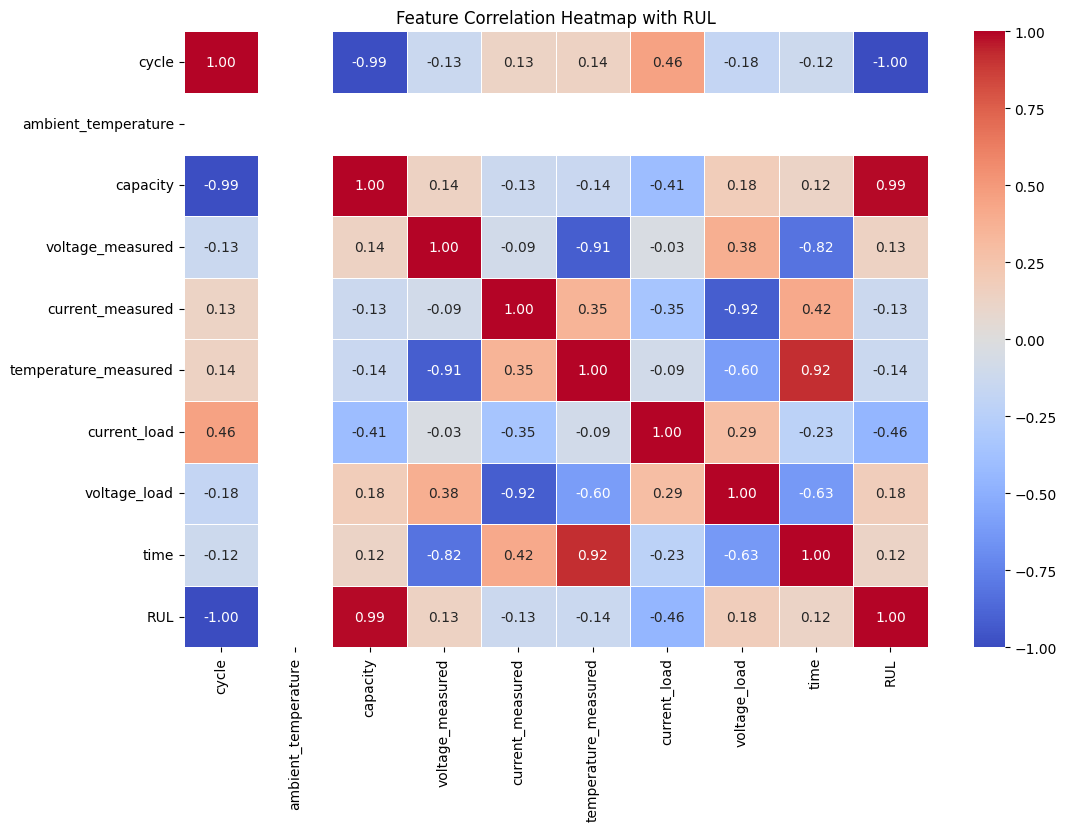

In [17]:
X_train, X_test, y_train, y_test = load_data()
X_train_, X_val, y_train_, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Run Genetic Algorithm for LSTM hyperparameter optimization

In [16]:
toolbox = setup_ga_lstm()

In [17]:
# best_lstm_params, loss_history =run_ga_lstm(toolbox, X_train, y_train, X_val, y_val, population_size=10, generations=10)
# print("Best LSTM Hyperparameters:", best_lstm_params)

# Train final optimized LSTM

In [18]:
best_lstm_model = build_lstm_model_ga(
    # lstm_units1=int(best_lstm_params[0]),
    # lstm_units2=int(best_lstm_params[1]),
    # lstm_units1=21.727444248649615,
    # lstm_units2=62.04324322403045,
    lstm_units1=64,
    lstm_units2=32,
    input_shape=(X_train.shape[1], X_train.shape[2]),
    # dropout_rate=0.3,
    learning_rate=0.001,
    optimizer_type=0
)

In [19]:
history = best_lstm_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=60, batch_size=32, verbose=1)
best_lstm_model.save("ltm_model.h5")

Epoch 1/60

1258/1258 [==============================] - 19s 11ms/step - loss: 6436.4365 - val_loss: 5193.8496
Epoch 2/60
1258/1258 [==============================] - 13s 11ms/step - loss: 4212.3447 - val_loss: 3346.2952
Epoch 3/60
1258/1258 [==============================] - 14s 11ms/step - loss: 2661.9409 - val_loss: 2090.7207
Epoch 4/60
1258/1258 [==============================] - 14s 11ms/step - loss: 1630.3497 - val_loss: 1250.3590
Epoch 5/60
1258/1258 [==============================] - 14s 11ms/step - loss: 951.0021 - val_loss: 707.9933
Epoch 6/60
1258/1258 [==============================] - 13s 11ms/step - loss: 522.6733 - val_loss: 375.8119
Epoch 7/60
1258/1258 [==============================] - 13s 11ms/step - loss: 269.2558 - val_loss: 187.1404
Epoch 8/60
1258/1258 [==============================] - 14s 11ms/step - loss: 130.5257 - val_loss: 87.2407
Epoch 9/60
1258/1258 [==============================] - 14s 11ms/step - loss: 59.3854 - val_loss: 38.1025
Epoch 10/60
1258/1258 

c:\Users\sarda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [20]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# Predict on validation set
lstm_preds = best_lstm_model.predict(X_val)

# If y_val is scaled, remember to inverse transform y_pred and y_val accordingly

# Evaluation metrics
mse = mean_squared_error(y_val, lstm_preds)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_val, lstm_preds)
r2 = r2_score(y_val, lstm_preds)

print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'R² Score: {r2}')


252/252 [==============================] - 2s 4ms/step
MSE: 0.009019558317959309
RMSE: 0.09497135524967151
MAE: 0.07880164682865143
R² Score: 0.999995768070221


In [21]:
print(X_test.shape)
print(y_test.shape)
print(lstm_preds.shape)

(10057, 9, 1)
(10057,)
(8046, 1)


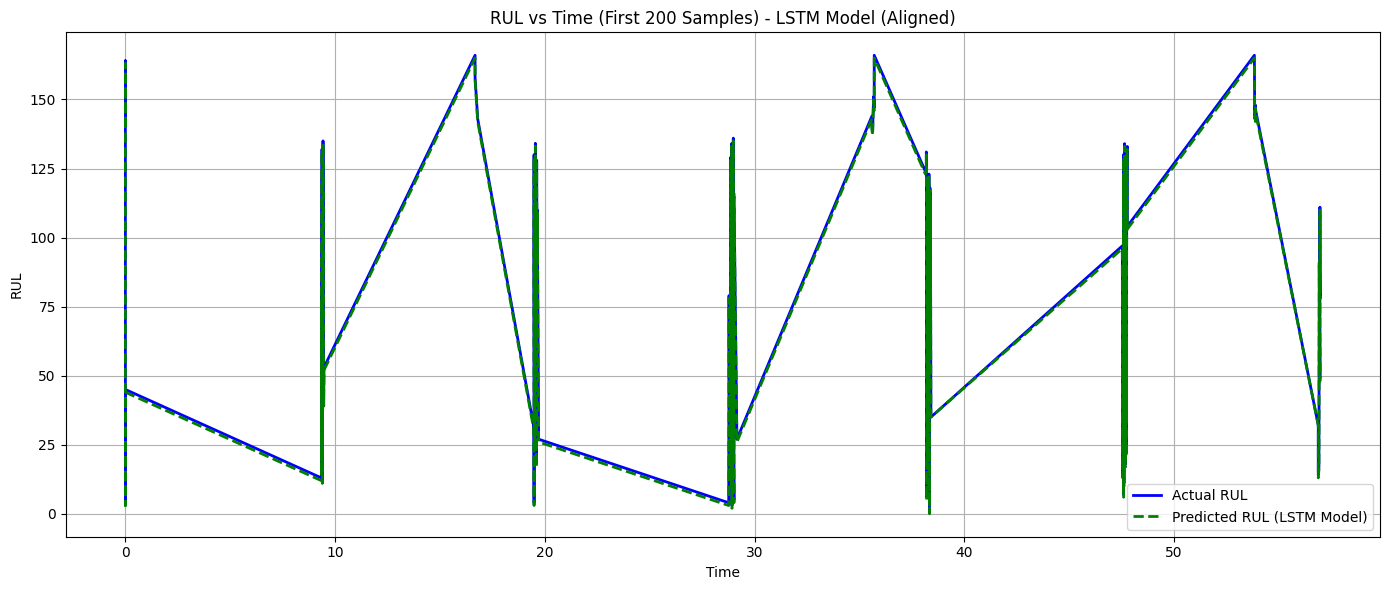

In [49]:
# Step 1: Reshape X_test
X_test_reshaped = X_test.reshape(X_test.shape[0], X_test.shape[1])

# Step 2: Get time values
time_values = X_test_reshaped[:, 8]  # Index 8 is time

# Step 3: Prepare actual RUL and predicted RUL
actual_rul = np.array(y_test).reshape(-1)  # Use full y_test
predicted_rul_lstm_full = np.zeros_like(actual_rul)  # Initialize empty array

# Step 4: Insert LSTM predictions into the last positions
predicted_rul_lstm_full[-len(lstm_preds):] = lstm_preds

# Step 5: Sort based on time
sorted_indices = np.argsort(time_values)
sorted_time = time_values[sorted_indices]
sorted_actual_rul = actual_rul[sorted_indices]
sorted_predicted_rul_lstm = predicted_rul_lstm_full[sorted_indices]

# Step 6: Plot
num_samples = 200  # Limit to first 200 sorted samples

plt.figure(figsize=(14, 6))
plt.plot(sorted_time[:num_samples], sorted_actual_rul[:num_samples], label='Actual RUL', color='blue', linewidth=2)
plt.plot(sorted_time[:num_samples], sorted_predicted_rul_lstm[:num_samples], label='Predicted RUL (LSTM Model)', color='green', linestyle='--', linewidth=2)

plt.title('RUL vs Time (First 200 Samples) - LSTM Model (Aligned)')
plt.xlabel('Time')
plt.ylabel('RUL')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

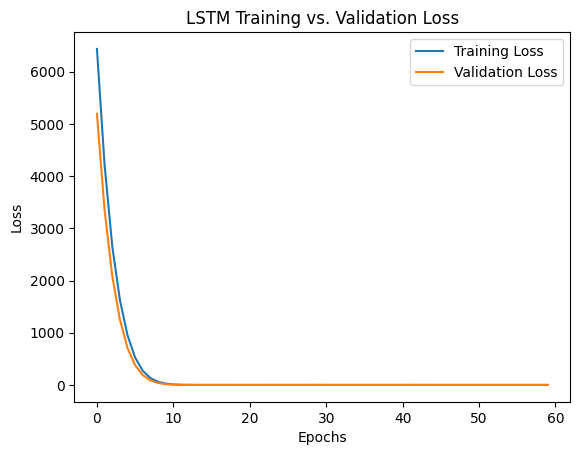

In [23]:
plot_loss(history)

In [24]:
# plot_ga_lstm_loss(loss_history)

In [25]:
svr_model=build_svr_model(X_train, X_test, y_train, y_test, mode='random')

Fitting 3 folds for each of 6 candidates, totalling 18 fits

✅ Best Params: {'gamma': 0.01, 'epsilon': 0.01, 'C': 10}

📊 SVR Evaluation Metrics:
Train MSE : 0.0210 | Test MSE : 0.0179
Train RMSE: 0.1448 | Test RMSE: 0.1337
Train MAE : 0.0650 | Test MAE : 0.0638
Train R²  : 1.0000 | Test R²  : 1.0000
Train EVS : 1.0000 | Test EVS : 1.0000


# Train and optimize LSTM-SVR fusion using GA

In [26]:
lstm_preds, svr_preds = get_predictions(best_lstm_model, svr_model, X_test)

315/315 [==============================] - 1s 4ms/step


In [27]:
print(lstm_preds)
print(svr_preds)

[ 31.99365   133.85556    84.95696   ...  69.9414      2.8443146
   9.917332 ]
[84.07303561 84.07303561 84.07303561 ... 84.07303561 84.07303561
 84.07303561]


In [39]:
fusion_toolbox = setup_ga()

c:\Users\sarda\AppData\Local\Programs\Python\Python310\lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
c:\Users\sarda\AppData\Local\Programs\Python\Python310\lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [40]:
best_ind, rmse_history = run_ga(fusion_toolbox, lstm_preds, svr_preds, y_test)

In [41]:
print(best_ind)
print(rmse_history)

1.0
0.0009281307769281656


In [42]:
print("Type of best_ind:", type(best_ind))
print("Value of best_ind:", best_ind)


Type of best_ind: <class 'float'>
Value of best_ind: 1.0


In [43]:
# Assume best_ind is the optimized weight for LSTM
w1_opt = best_ind
w2_opt = 1 - best_ind  # Remaining weight goes to SVR

# Combine predictions using weighted average
final_preds = w1_opt * lstm_preds + w2_opt * svr_preds

final_mse = mean_squared_error(y_test, final_preds)
final_rmse = np.sqrt(final_mse)
final_mae = mean_absolute_error(y_test, final_preds)
final_r2 = r2_score(y_test, final_preds)


In [44]:
print("Optimized Weights for Fusion:", best_ind)
print(f"MSE: {final_mse}")
print(f"RMSE: {final_rmse}")
print(f"MAE: {final_mae}")
print(f"R² Score: {final_r2}")

Optimized Weights for Fusion: 1.0
MSE: 0.00897736017984182
RMSE: 0.09474893234143496
MAE: 0.07858006186332145
R² Score: 0.9999957072987407


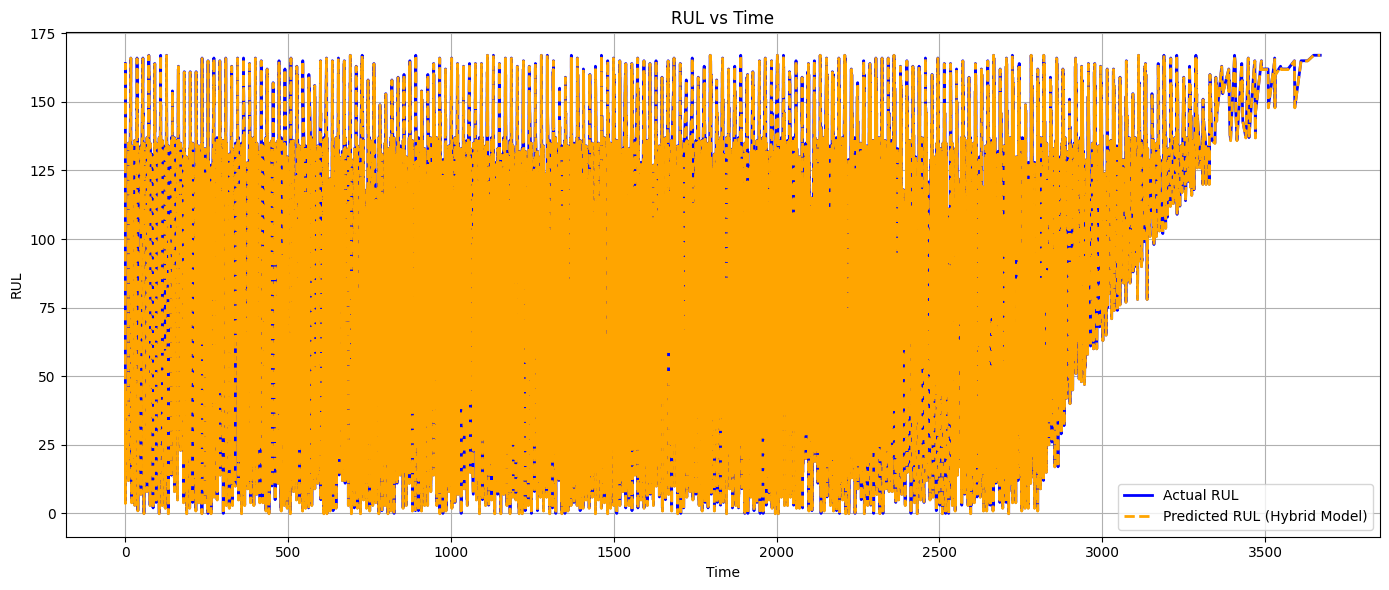

In [45]:
X_test_reshaped = X_test.reshape(X_test.shape[0], X_test.shape[1])  # remove last dimension
time_values = X_test_reshaped[:, 8]  # Index 8 is time

actual_rul = np.array(y_test).reshape(-1)
predicted_rul = np.array(final_preds).reshape(-1)

sorted_indices = np.argsort(time_values)
sorted_time = time_values[sorted_indices]
sorted_actual_rul = actual_rul[sorted_indices]
sorted_predicted_rul = predicted_rul[sorted_indices]

plt.figure(figsize=(14, 6))
plt.plot(sorted_time, sorted_actual_rul, label='Actual RUL', color='blue', linewidth=2)
plt.plot(sorted_time, sorted_predicted_rul, label='Predicted RUL (Hybrid Model)', color='orange', linestyle='--', linewidth=2)

plt.title('RUL vs Time')
plt.xlabel('Time')
plt.ylabel('RUL')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

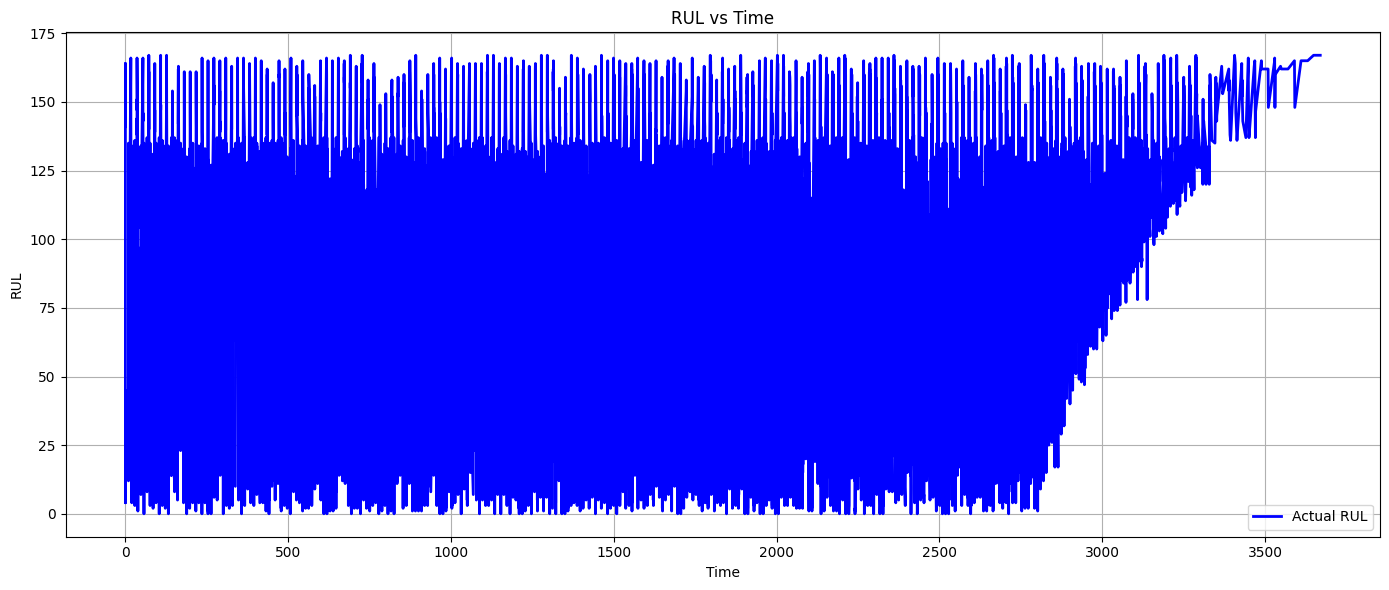

In [46]:
X_test_reshaped = X_test.reshape(X_test.shape[0], X_test.shape[1])  # remove last dimension
time_values = X_test_reshaped[:, 8]  # Index 8 is time

actual_rul = np.array(y_test).reshape(-1)
predicted_rul = np.array(final_preds).reshape(-1)

sorted_indices = np.argsort(time_values)
sorted_time = time_values[sorted_indices]
sorted_actual_rul = actual_rul[sorted_indices]
sorted_predicted_rul = predicted_rul[sorted_indices]

plt.figure(figsize=(14, 6))
plt.plot(sorted_time, sorted_actual_rul, label='Actual RUL', color='blue', linewidth=2)
# plt.plot(sorted_time, sorted_predicted_rul, label='Predicted RUL (Hybrid Model)', color='orange', linestyle='--', linewidth=2)

plt.title('RUL vs Time')
plt.xlabel('Time')
plt.ylabel('RUL')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

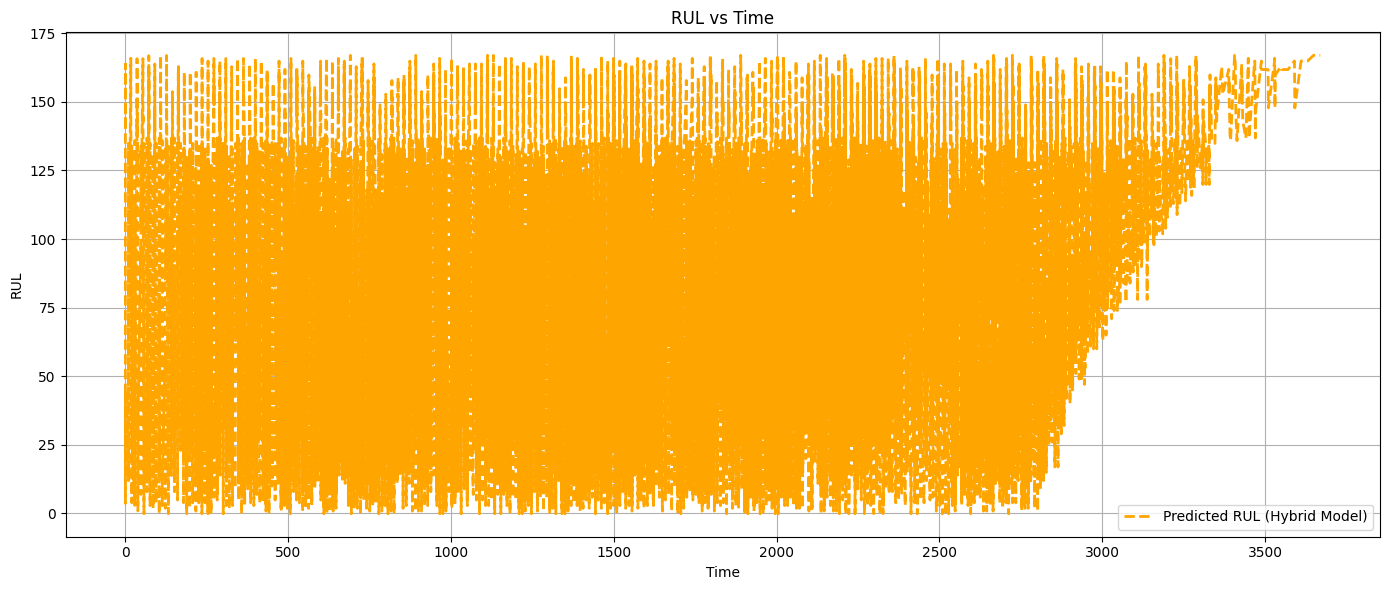

In [47]:
X_test_reshaped = X_test.reshape(X_test.shape[0], X_test.shape[1])  # remove last dimension
time_values = X_test_reshaped[:, 8]  # Index 8 is time

actual_rul = np.array(y_test).reshape(-1)
predicted_rul = np.array(final_preds).reshape(-1)

sorted_indices = np.argsort(time_values)
sorted_time = time_values[sorted_indices]
sorted_actual_rul = actual_rul[sorted_indices]
sorted_predicted_rul = predicted_rul[sorted_indices]

plt.figure(figsize=(14, 6))
# plt.plot(sorted_time, sorted_actual_rul, label='Actual RUL', color='blue', linewidth=2)
plt.plot(sorted_time, sorted_predicted_rul, label='Predicted RUL (Hybrid Model)', color='orange', linestyle='--', linewidth=2)

plt.title('RUL vs Time')
plt.xlabel('Time')
plt.ylabel('RUL')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

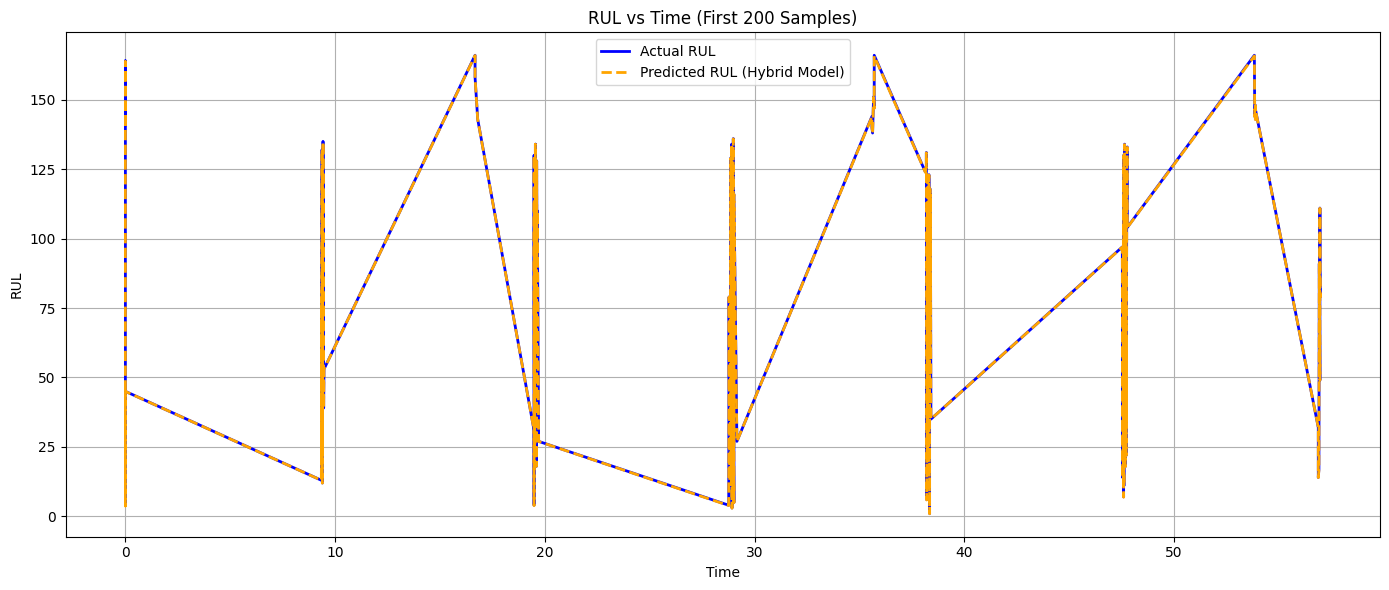

In [48]:
X_test_reshaped = X_test.reshape(X_test.shape[0], X_test.shape[1])  # remove last dimension
time_values = X_test_reshaped[:, 8]  # Index 8 is time

actual_rul = np.array(y_test).reshape(-1)
predicted_rul = np.array(final_preds).reshape(-1)

sorted_indices = np.argsort(time_values)
sorted_time = time_values[sorted_indices]
sorted_actual_rul = actual_rul[sorted_indices]
sorted_predicted_rul = predicted_rul[sorted_indices]

# Limit to first 200 sorted samples
num_samples = 200

plt.figure(figsize=(14, 6))
plt.plot(sorted_time[:num_samples], sorted_actual_rul[:num_samples], label='Actual RUL', color='blue', linewidth=2)
plt.plot(sorted_time[:num_samples], sorted_predicted_rul[:num_samples], label='Predicted RUL (Hybrid Model)', color='orange', linestyle='--', linewidth=2)

plt.title('RUL vs Time (First 200 Samples)')
plt.xlabel('Time')
plt.ylabel('RUL')   
plt.legend()
plt.grid(True)
plt.tight_layout() 
plt.show()

